# Distributing a Dask Cluster Between Data Centres

## Summary

We have devised a technique for creating a Dask cluster where worker nodes are hosted in different data centres, connected by a mesh VPN that allows the scheduler and workers to communicate and exchange results. 

A novel (ab)use of Dask resources allows us to run data processing tasks on the workers in the cluster closest to the source data, so that communication between data centres is minimised. If combined with zarr to give access to huge hyper-cube datasets in object storage, we believe that the technique could realise the potential of data-proximate distributed computing in the Cloud.

## Introduction

The UK Met Office has been carrying out a study into data-proximate computing, in collaboration with the European Weather Cloud. We identified Dask as a key technology, but whilst existing Dask techniques focus on parallel computation in a single data centre, we looked to extend this to computation across data centres. This way, when the data required is hosted in multiple locations, tasks can be run where the data is rather than copying it.

Dask worker nodes freely exchange data chunks as coordinated by a scheduler. There is an assumption that they are all on the same network, which is not generally true across data centres, so a truly distributed approach has to solve this problem. In addition, it has to manage data transfer efficiently, because moving data chunks between data centres is much more costly than between workers in the same cloud.

This notebook documents a running proof-of-concept that addresses these problems. It runs a computation in 3 locations.

1. This computer, where the client and scheduler are running.
2. The ECMWF data centre. This has compute resources, and hosts data containing *predictions*.
3. The EUMETSAT data centre, with compute resources and data on *observations*

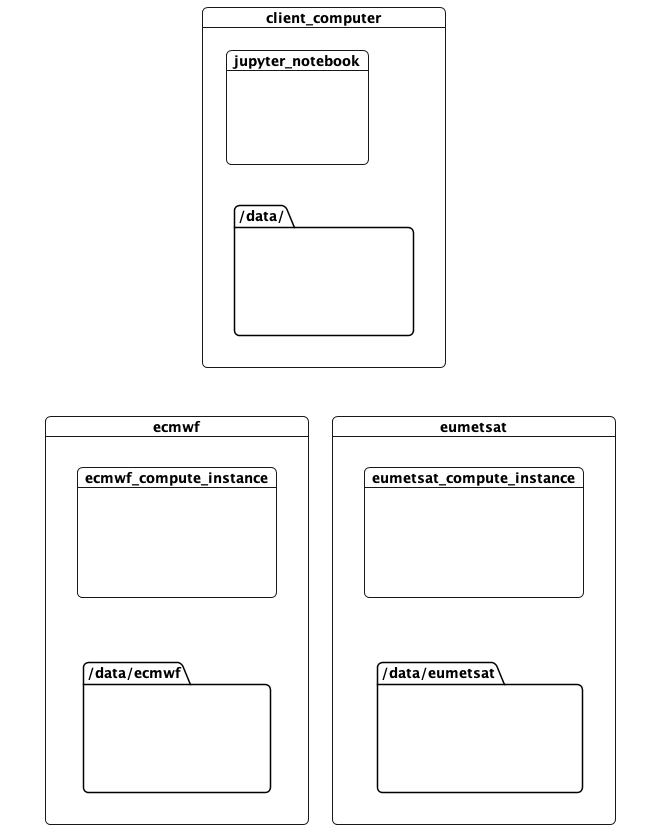

In [1]:
from IPython.display import Image
Image(filename="images/datacentres.png") # this because GitHub doesn't render markup images in private repos

The idea is that tasks accessing data available in a location should be run there. Meanwhile the computation can be defined, invoked, and the results rendered, elsewhere. All this with minimal hinting to the computation as to how this should be done.

## Setup 

First some imports and conveniences

In [2]:
import os
from time import sleep
import dask
from dask.distributed import Client
from dask.distributed import performance_report, get_task_stream
from dask_worker_pools import pool, propagate_pools
import pytest
import ipytest
import xarray
import matplotlib.pyplot as plt
from orgs import my_org
from tree import tree

ipytest.autoconfig()

In this case we are using a control plane IPv4 WireGuard network on 10.8.0.0/24 to set up the cluster. WireGuard is running on ECMWF and EUMETSAT, but we have to start it here

In [3]:
!./start-wg.sh

4: mo-aws-ec2: <POINTOPOINT,NOARP,UP,LOWER_UP> mtu 8921 qdisc noqueue state UNKNOWN group default qlen 1000
    link/none 
    inet 10.8.0.3/24 scope global mo-aws-ec2
       valid_lft forever preferred_lft forever


We have worker machines configured in both ECMWF and EUMETSAT, one in each. They are accessible on the control plane network as

In [4]:
ecmwf_host='10.8.0.4'
%env ECMWF_HOST=$ecmwf_host
eumetsat_host='10.8.0.2'
%env EUMETSAT_HOST=$eumetsat_host

env: ECMWF_HOST=10.8.0.4
env: EUMETSAT_HOST=10.8.0.2


## Mount the Data

This machine needs access to the data files over the network in order to read NetCDF metadata. The workers are sharing their data with NFS, so we mount them here (over the control plane network, but see Future Work below)

In [5]:
%%bash
sudo ./data-reset.sh

mkdir -p /data/ecmwf
mkdir -p /data/eumetsat
sudo mount $ECMWF_HOST:/data/ecmwf /data/ecmwf
sudo mount $EUMETSAT_HOST:/eumetsatdata/ /data/eumetsat

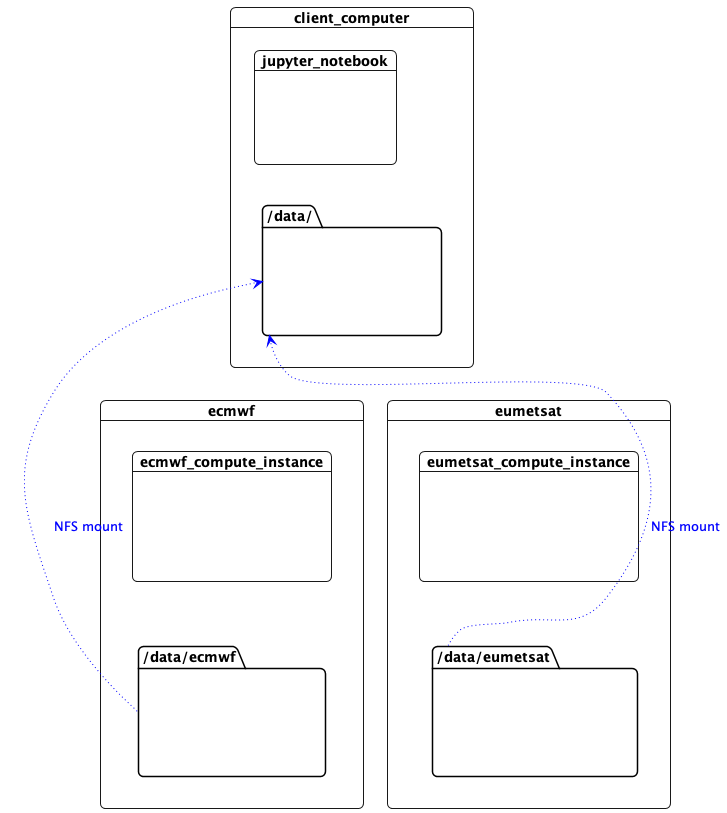

In [6]:
Image(filename="images/datacentres-data.png")

## Access to Data

For this demonstration, we have two large data files that we want to process. On ECMWF we have predictions in `/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc`. Workers running in ECMWF can see the file

In [7]:
!ssh -i ~/.ssh/id_rsa_rcar_infra  rcar@$ECMWF_HOST 'tree /data/'

/data/
└── ecmwf
    └── 000490262cdd067721a34112963bcaa2b44860ab.nc

1 directory, 1 file


and because that directory is mounted here over NFS, so can this computer

In [8]:
!tree /data/ecmwf

/data/ecmwf
└── 000490262cdd067721a34112963bcaa2b44860ab.nc

0 directories, 1 file


On EUMETSAT we have `observations.nc`

In [9]:
!ssh -i ~/.ssh/id_rsa_rcar_infra  rcar@$EUMETSAT_HOST 'tree /data/eumetsat/ad-hoc'

/data/eumetsat/ad-hoc
└── observations.nc

0 directories, 1 file


similarly visible on this computer

In [10]:
!tree /data/eumetsat/ad-hoc

/data/eumetsat/ad-hoc
└── observations.nc

0 directories, 1 file


ECMWF data is not visible in the EUMETSAT data centre, and vice versa.

## Our Calculation

We want to compare the predictions against the observations.

We can open the predictions file with xarray

In [11]:
predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')
predictions

<xarray.Dataset>
Dimensions:                  (realization: 18, height: 33, latitude: 960,
                              longitude: 1280, bnds: 2)
Coordinates:
  * realization              (realization) int32 0 18 19 20 21 ... 31 32 33 34
  * height                   (height) float32 5.0 10.0 20.0 ... 5.5e+03 6e+03
  * latitude                 (latitude) float32 -89.91 -89.72 ... 89.72 89.91
  * longitude                (longitude) float32 -179.9 -179.6 ... 179.6 179.9
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    time                     datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    air_pressure             (realization, height, latitude, longitude) float32 dask.array<chunksize=(18, 33, 192, 160), meta=np.ndarray>
    latitude_longitude       int32 ...
    latitude_bnds            (latitude, bnds) float32 dask.array<chunksize=(960, 2), meta=np.ndarray>
    longitude_bnds           (longitude, bnds) float32 dask.array<chunksize=(1280, 2), meta=np.ndarray>
Attributes:
    history:                      2021-11-07T10:27:38Z: StaGE Decoupler
    institution:                  Met Office
    least_significant_digit:      1
    mosg__forecast_run_duration:  PT198H
    mosg__grid_domain:            global
    mosg__grid_type:              standard
    mosg__grid_version:           1.6.0
    mosg__model_configuration:    gl_ens
    source:                       Met Office Unified Model
    title:                        MOGREPS-G Model Forecast on Global 20 km St...
    um_version:                   11.5
    Conventions:                  CF-1.7

Dask code running on this machine has read the metadata for the file via NFS. 

Likewise we can see the observations, so we can perform a calculation locally. Here we average the predictions over the realisations and then compare them with the observations at a particular height. (This is a deliberately inefficient calculation, as we could average at only the required height, but this is pedagogical.)

In [12]:
%%time
def scope():
    client = Client()
    predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')
    observations = xarray.open_dataset('/data/eumetsat/ad-hoc/observations.nc').chunk('auto')    

    averages = predictions.mean('realization')
    diff = averages.isel(height=10) - observations
    diff.compute()
    
#scope()    

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.7 µs


When we uncomment `scope()` and actually run this, it takes some 18 minutes to complete! Accessing the data over NFS between data centres (we run this notebook in  AWS) is just too slow.

Instead we should obviously run the Dask tasks where the data is. We can do that on a Dask cluster.

## Running Up a Cluster

The cluster is run up with a single command. It takes a while though

In [13]:
import subprocess

scheduler_process = subprocess.Popen([
        '../dask_multicloud/start-cluster.sh', 
        f"rcar@{ecmwf_host}",
        f"rcar@{eumetsat_host}"
    ])

[#] ip link add dasklocal type wireguard
[#] wg setconf dasklocal /dev/fd/63
[#] ip -6 address add fda5:c0ff:eeee:0::1/64 dev dasklocal
[#] ip link set mtu 1420 up dev dasklocal
[#] ip -6 route add fda5:c0ff:eeee:2::/64 dev dasklocal
[#] ip -6 route add fda5:c0ff:eeee:1::/64 dev dasklocal
2022-06-21 13:56:19,720 - distributed.scheduler - INFO - -----------------------------------------------
2022-06-21 13:56:20,930 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2022-06-21 13:56:20,980 - distributed.scheduler - INFO - -----------------------------------------------
2022-06-21 13:56:20,982 - distributed.scheduler - INFO - Clear task state
2022-06-21 13:56:20,982 - distributed.scheduler - INFO -   Scheduler at:     tcp://172.17.0.2:8786
2022-06-21 13:56:20,983 - distributed.scheduler - INFO -   dashboard at:                     :8787
2022-06-21 13:56:57,120 - distributed.comm.tcp 

We need to wait for 8 `distributed.core - INFO - Starting established connection` lines - one from each of 4 worker processes on each of 2 worker machines.

What has happened here is:

1. `start-scheduler.sh` runs up a Docker container on this computer.
2. The container creates a WireGuard IPv6 data plane VPN. This involves generating shared keys for all the nodes and a network interface inside itself. This data plane VPN is transient and unique to this cluster.
3. The container runs a Dask scheduler, hosted on the data plane network.
4. It then asks each data centre to provision workers and routing.

Each data centre hosts a control process, accessible over the control plane network. On invocation:

1. The control process creates a WireGuard network interface on the data plane network. This acts as a router between the data centres and the scheduler.
2. It starts Docker containers on compute instances. These containers have their own WireGuard network interface on the data plane network.
3. The Docker containers spawn (4) Dask worker processes, each of which connects via the data plane network back to the scheduler created at the beginning.

The result is one container on this computer running the scheduler, talking to a container on each worker machine, over a throw-away data plane WireGuard IPv6 network which allows each of the (in this case 8) Dask worker processes to communicate with each other and the scheduler, even though they are partitioned over 3 data centres.

Something like this

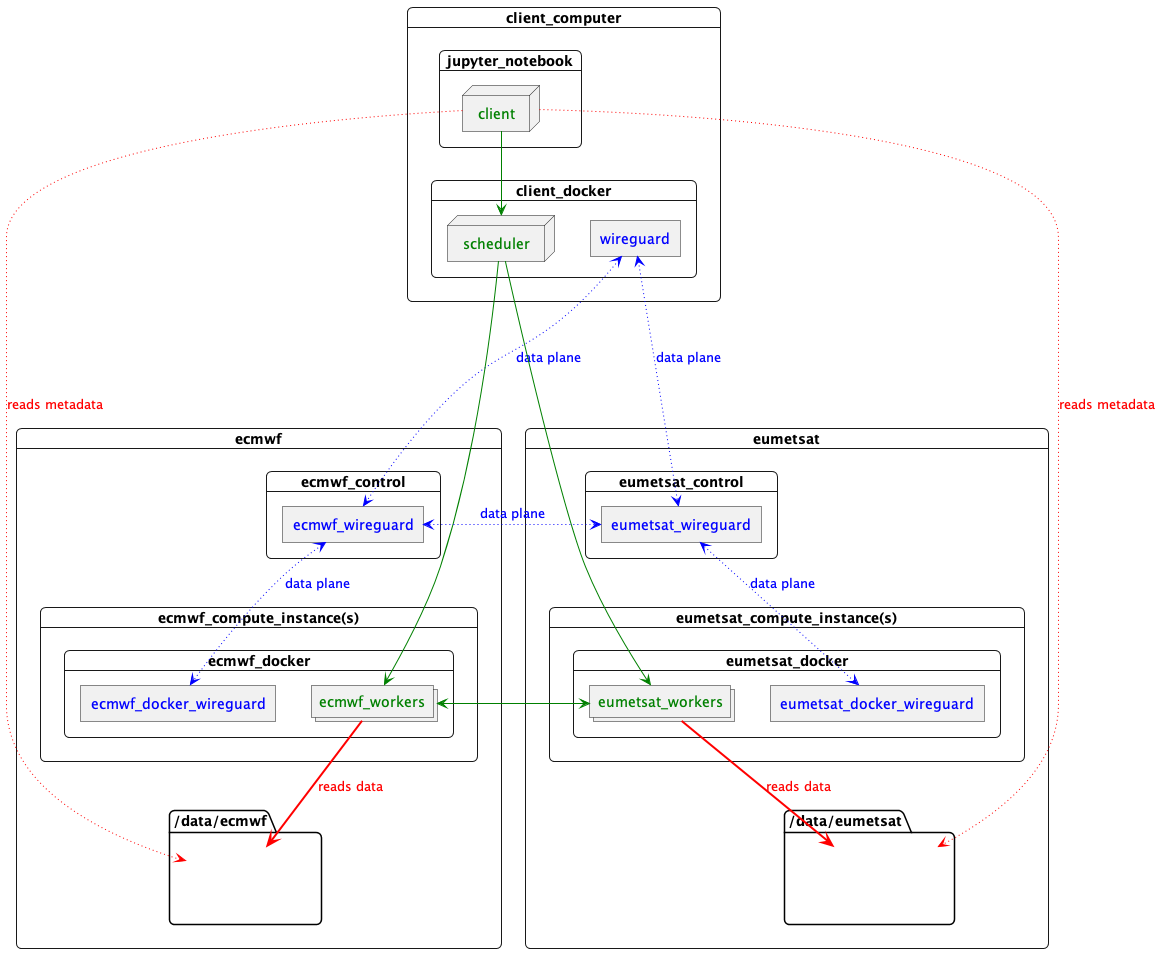

In [14]:
Image(filename="images/datacentres-dask.png")

Key

* <span style='color: blue'>Data plane network</span>
* <span style='color: green'>Dask</span>
* <span style='color: red'>NetCDF data</span>

## Connecting to the Cluster

The scheduler for the cluster is running in a Docker container on this machine and is exposed on `localhost`, so we can create a client talking to it

In [15]:
client = Client("localhost:8786")

2022-06-21 13:57:22,990 - distributed.scheduler - INFO - Receive client connection: Client-1307589d-f16a-11ec-a197-0acd18a5c05a
2022-06-21 13:57:22,992 - distributed.core - INFO - Starting established connection
/home/ec2-user/miniconda3/envs/jupyter/lib/python3.10/site-packages/distributed/client.py:1287: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| lz4     | 4.0.0  | 3.1.3     | 3.1.3   |
| msgpack | 1.0.3  | 1.0.2     | 1.0.2   |
| numpy   | 1.22.3 | 1.21.5    | 1.21.5  |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


If you click through the client you should see the workers under the `Scheduler Info` node

In [16]:
# client

You can also click through to the Dashboard on http://localhost:8787/status. There we can show the workers on the task stream

In [17]:
def show_all_workers():
    my_org().compute(workers='ecmwf-1-0')
    my_org().compute(workers='ecmwf-1-1')
    my_org().compute(workers='ecmwf-1-2')
    my_org().compute(workers='ecmwf-1-3')
    my_org().compute(workers='eumetsat-2-0')
    my_org().compute(workers='eumetsat-2-1')
    my_org().compute(workers='eumetsat-2-2')
    my_org().compute(workers='eumetsat-2-3')
    sleep(0.5)

show_all_workers()

## Running on the Cluster

Now that there is a Dask client in scope, calculations will be run on the cluster. We can define the tasks to be run

In [18]:
predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')
observations = xarray.open_dataset('/data/eumetsat/ad-hoc/observations.nc').chunk('auto')    
    
averages = predictions.mean('realization')
diff = averages.isel(height=10) - observations

But when we try to perform the calculation it fails

In [19]:
with pytest.raises(FileNotFoundError) as excinfo:
    show_all_workers()
    diff.compute()    

str(excinfo.value)

"[Errno 2] No such file or directory: b'/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc'"

It fails because the Dask scheduler has sent some of the tasks to read the data to workers running in EUMETSAT. They cannot see the data in ECMWF, and nor do we want them too, because reading all that data between data centres would be too slow.

# Data-Proximate Computation

Dask has the concept of [resources](https://distributed.dask.org/en/stable/resources.html). Tasks can be scheduled to run only where a resource (such as a GPU or amount of RAM) is available. We can [abuse this mechanism](https://dask.discourse.group/t/understanding-work-stealing/335/13) to pin tasks to a data centre, by treating the data centre as a resource.

To do this, when we create the workers we mark them as having a `pool-ecmwf` or `pool-eumetsat` resource. Then when we want to create tasks that can only run in one data centre, we annotate them as requiring the appropriate resource

In [20]:
with (dask.annotate(resources={'pool-ecmwf': 1})):
    predictions.isel(height=10).compute()

A [special Python context manager](https://github.com/gjoseph92/dask-worker-pools) can hide the nastiness, allowing us to run a calculation only where the data is available

In [21]:
with pool('ecmwf'):    
    predictions.isel(height=10).compute()

Better still, we can load the data inside the context manager block and it will carry the task annonation with it

In [22]:
with pool('ecmwf'):
    predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')

Another context manager in the library, `propagate_pools`, ensures that this resource pinning is respected

In [23]:
with propagate_pools():
    predictions.isel(height=10).compute()

This allows us to mark data with its pool

In [24]:
with pool('ecmwf'):    
    predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')

with pool('eumetsat'):
    observations = xarray.open_dataset('/data/eumetsat/ad-hoc/observations.nc').chunk('auto')

define some deferred calculations oblivious to its provenance

In [25]:
averaged_predictions = predictions.mean('realization')
diff = averaged_predictions.isel(height=10) - observations

and then perform the final calculation

In [26]:
%%time 
with propagate_pools():
    show_all_workers()
    diff.compute()

CPU times: user 135 ms, sys: 16.2 ms, total: 151 ms
Wall time: 16.6 s


Remember, our aim was to distribute a calculation across data centres, whilst preventing workers reading foreign bulk data.

Here, we know that data is only being read by workers in the appropriate location, because neither data centre can read the other's data. Once data is in memory, Dask prefers to schedule tasks on the workers that have it, so that the local workers will tend to perform follow-on calcuations.

Ordinarily though, Dask would use idle workers to perform calculations even if they don't have the data. If allowed, this work stealing would result in unreduced data being moved between data centres, a potentially expensive operation, so the `propagate_pools` context manager also prevents work-stealing between workers in different pools.

Once data loaded in one pool needs to be combined with data from another (the substraction in `averaged_predictions.isel(height=10) - observations` above) this is no longer classified as work stealing, and Dask will move data between data centres as required.

That calculation in one go looks like this

CPU times: user 222 ms, sys: 24.3 ms, total: 247 ms
Wall time: 24.1 s


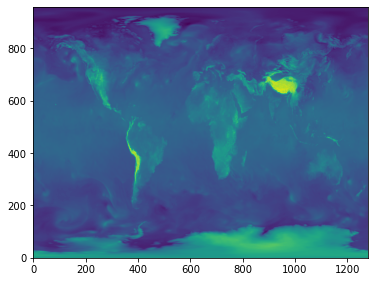

In [27]:
%%time
with pool('ecmwf'):    
    predictions = xarray.open_dataset('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc').chunk('auto')

with pool('eumetsat'):
    observations = xarray.open_dataset('/data/eumetsat/ad-hoc/observations.nc').chunk('auto')   

averages = predictions.mean('realization')
diff = averages.isel(height=10) - observations
    
with propagate_pools():
    show_all_workers()
    plt.figure(figsize=(6, 6))
    plt.imshow(diff.to_array()[0,...,0], origin='lower')

In terms of code, compared with the local version above, this has only added the use of `with` blocks to label data and manage execution, and executes some 40 times faster.

## Catalogs

We can simplify this code even more. Because the data-loading tasks are labelled with their resource pool, this can be opaque to the scientist. So we can write

In [28]:
def load_from_catalog(path):
    with pool(path.split('/')[2]):
        return xarray.open_dataset(path).chunk('auto')

allowing us to ignore where the data came from

In [29]:
predictions = load_from_catalog('/data/ecmwf/000490262cdd067721a34112963bcaa2b44860ab.nc')
observations = load_from_catalog('/data/eumetsat/ad-hoc/observations.nc')  

averages = predictions.mean('realization')
diff = averages.isel(height=10) - observations

with propagate_pools():
    show_all_workers()
    diff.compute()

Of course the cluster would have to be provisioned with compute resources in the appropriate data centres, although with some work this could be made dynamic as part of the catalog code.


## More Information

This notebook, and the code behind it, are published in a [GitHub repository](https://github.com/dmcg/dask-multicloud-poc). 

For details of the prototype implementation, and ideas for enhancements, see
[dask-multi-cloud-details.ipynb](./dask-multi-cloud-details.ipynb).